### Регрессия для CC50

In [16]:
import numpy as np
import pandas as pd

In [11]:
df_scaled = pd.read_csv('df_scaled.csv')

In [3]:
df_scaled.shape

(969, 188)

In [4]:
df_scaled.head()

,IC50,CC50,SI,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,...,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea
0,-0.599333,-0.648886,0.023693,-1.766931,-1.766931,1.230105,0.859969,-0.751719,1.076111,0.260487,...,-0.179370,-0.211946,-0.111979,-0.096825,-0.032141,-0.032141,-0.238132,-0.274721,2.268081,-0.085302
1,-0.623447,-0.917447,-0.258103,-2.112017,-2.112017,2.098636,0.953566,-0.540135,1.257528,0.292155,...,-0.179370,-0.211946,-0.111979,-0.096825,-0.032141,-0.032141,-0.238132,-0.274721,2.268081,-0.085302
2,0.360199,-0.671529,-0.341875,-2.518530,-2.518530,2.154087,0.959542,-1.485466,1.017293,0.748665,...,6.379466,-0.211946,-0.111979,-0.096825,-0.032141,-0.032141,-0.238132,-0.274721,2.268081,-0.085302
3,-0.619328,-0.755671,0.492044,-1.765937,-1.765937,1.250111,0.862125,-0.937063,0.991464,0.370656,...,-0.179370,-0.211946,-0.111979,-0.096825,-0.032141,-0.032141,-0.238132,-0.274721,3.080565,-0.085302
4,-0.154375,-0.706065,-0.334138,-1.749744,-1.749744,0.538633,0.785453,-0.696952,0.567012,0.905000,...,-0.179370,-0.211946,-0.111979,-0.096825,-0.032141,-0.032141,-0.238132,-0.274721,-0.169372,-0.085302


### Сравнены различные модели с настройкой гиперпараметров, сделаны выводы о применимости методов, даны рекомендации по улучшению.

In [12]:
import joblib
import matplotlib.pyplot as plt
import optuna
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

# Загрузка данных

y = df_scaled['CC50']  # Целевая переменная
X = df_scaled.drop(columns=['SI', 'CC50', 'IC50'])  # Признаки

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Словарь регрессоров для оптимизации
REGRESSORS = {
    'XGBRegressor': XGBRegressor,
    'DecisionTreeRegressor': DecisionTreeRegressor,
    'RandomForestRegressor': RandomForestRegressor,
    'CatBoostRegressor': CatBoostRegressor
}

def objective(trial, regressor_name):
    """Оптимизация гиперпараметров."""
    if regressor_name == 'XGBRegressor':
        params = {
            'objective': 'reg:squarederror',
            'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1.0, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 15),
            'n_estimators': trial.suggest_int('n_estimators', 50, 550),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        }
        model = XGBRegressor(**params)
        
    elif regressor_name == 'DecisionTreeRegressor':
        params = {
            'max_depth': trial.suggest_int('max_depth', 1, 15),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        }
        model = DecisionTreeRegressor(**params)

    elif regressor_name == 'RandomForestRegressor':
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 550),
            'max_depth': trial.suggest_int('max_depth', 1, 15),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        }
        model = RandomForestRegressor(**params)

    elif regressor_name == 'CatBoostRegressor':
        params = {
            'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1.0, log=True),
            'depth': trial.suggest_int('depth', 1, 10),
            'iterations': trial.suggest_int('iterations', 50, 550),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-4, 10, log=True),
            'verbose': 0  
        }
        model = CatBoostRegressor(**params)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Используем только MSE для оптимизации
    mse = mean_squared_error(y_test, y_pred)
    return mse

# Оптимизация гиперпараметров для каждого регрессора
best_models = {}
for regressor_name in REGRESSORS.keys():
    print(f"Оптимизация гиперпараметров для {regressor_name}...")
    study = optuna.create_study(direction='minimize')  # Минимизируем только MSE
    study.optimize(lambda trial: objective(trial, regressor_name), n_trials=250)

    # Получаем наилучшие параметры и модель
    best_trial = study.best_trial
    best_model = REGRESSORS[regressor_name](**best_trial.params).fit(X_train, y_train)
    best_models[regressor_name] = {
        'best_params': best_trial.params,
        'best_model': best_model,
    }

    print(f"Оптимальные гиперпараметры для {regressor_name}:", best_trial.params)

# Оценка всех моделей на тестовой выборке
for regressor_name, model_data in best_models.items():
    best_model = model_data['best_model']
    y_test_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test, y_test_pred)
    mae = mean_absolute_error(y_test, y_test_pred)
    r2 = r2_score(y_test, y_test_pred)

    print(f"{regressor_name} - Тестовый MSE: {mse}, Тестовый MAE: {mae}, Тестовый R^2: {r2}")


[I 2025-05-23 23:10:46,313] A new study created in memory with name: no-name-53c7e28a-9ab1-4b51-af71-d8533ca7cdbc


Оптимизация гиперпараметров для XGBRegressor...


[I 2025-05-23 23:10:49,115] Trial 0 finished with value: 0.47884593798775504 and parameters: {'learning_rate': 0.009106456202438466, 'max_depth': 14, 'n_estimators': 231, 'subsample': 0.5657182158985627, 'colsample_bytree': 0.7874638459292818}. Best is trial 0 with value: 0.47884593798775504.
[I 2025-05-23 23:10:49,795] Trial 1 finished with value: 0.5634032112094854 and parameters: {'learning_rate': 0.10200929340759195, 'max_depth': 4, 'n_estimators': 501, 'subsample': 0.6774683374167907, 'colsample_bytree': 0.9454214323813264}. Best is trial 0 with value: 0.47884593798775504.
[I 2025-05-23 23:10:53,611] Trial 2 finished with value: 0.6812387960270072 and parameters: {'learning_rate': 0.0022043459005341177, 'max_depth': 15, 'n_estimators': 248, 'subsample': 0.8750251620769983, 'colsample_bytree': 0.9962178958596857}. Best is trial 0 with value: 0.47884593798775504.
[I 2025-05-23 23:10:58,044] Trial 3 finished with value: 0.9344568757673142 and parameters: {'learning_rate': 0.000359611

Оптимальные гиперпараметры для XGBRegressor: {'learning_rate': 0.014571209285123109, 'max_depth': 6, 'n_estimators': 174, 'subsample': 0.9852988028223666, 'colsample_bytree': 0.5260039731748978}
Оптимизация гиперпараметров для DecisionTreeRegressor...


[I 2025-05-23 23:13:53,537] Trial 8 finished with value: 0.5484225841673173 and parameters: {'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 9}. Best is trial 5 with value: 0.5436050107016283.
[I 2025-05-23 23:13:53,565] Trial 9 finished with value: 0.5345803430903355 and parameters: {'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 9}. Best is trial 9 with value: 0.5345803430903355.
[I 2025-05-23 23:13:53,625] Trial 10 finished with value: 0.7395216185929724 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 9 with value: 0.5345803430903355.
[I 2025-05-23 23:13:53,659] Trial 11 finished with value: 0.5383794337553774 and parameters: {'max_depth': 11, 'min_samples_split': 4, 'min_samples_leaf': 10}. Best is trial 9 with value: 0.5345803430903355.
[I 2025-05-23 23:13:53,693] Trial 12 finished with value: 0.5447135288461077 and parameters: {'max_depth': 11, 'min_samples_split': 4, 'min_samples_leaf': 10}. Best is trial 

Оптимальные гиперпараметры для DecisionTreeRegressor: {'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 2}
Оптимизация гиперпараметров для RandomForestRegressor...


[I 2025-05-23 23:14:03,460] Trial 0 finished with value: 0.4775073080667044 and parameters: {'n_estimators': 59, 'max_depth': 14, 'min_samples_split': 3, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.4775073080667044.
[I 2025-05-23 23:14:12,993] Trial 1 finished with value: 0.44628614083689633 and parameters: {'n_estimators': 482, 'max_depth': 11, 'min_samples_split': 10, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.44628614083689633.
[I 2025-05-23 23:14:15,261] Trial 2 finished with value: 0.4659430936785757 and parameters: {'n_estimators': 175, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.44628614083689633.
[I 2025-05-23 23:14:16,216] Trial 3 finished with value: 0.8804235255052127 and parameters: {'n_estimators': 339, 'max_depth': 1, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.44628614083689633.
[I 2025-05-23 23:14:16,646] Trial 4 finished with value: 0.8412183274069004 and parameter

Оптимальные гиперпараметры для RandomForestRegressor: {'n_estimators': 254, 'max_depth': 12, 'min_samples_split': 6, 'min_samples_leaf': 3}
Оптимизация гиперпараметров для CatBoostRegressor...


[I 2025-05-23 23:43:31,231] Trial 0 finished with value: 0.49114996395302496 and parameters: {'learning_rate': 0.22517474708807486, 'depth': 2, 'iterations': 52, 'l2_leaf_reg': 0.02740934973632877}. Best is trial 0 with value: 0.49114996395302496.
[I 2025-05-23 23:44:14,159] Trial 1 finished with value: 0.4723335679078268 and parameters: {'learning_rate': 0.02204076410689304, 'depth': 10, 'iterations': 481, 'l2_leaf_reg': 9.824937097149753}. Best is trial 1 with value: 0.4723335679078268.
[I 2025-05-23 23:44:14,388] Trial 2 finished with value: 1.0152233964346835 and parameters: {'learning_rate': 0.001139913675911575, 'depth': 2, 'iterations': 222, 'l2_leaf_reg': 0.00041594042823194535}. Best is trial 1 with value: 0.4723335679078268.
[I 2025-05-23 23:44:14,834] Trial 3 finished with value: 1.0757844123099178 and parameters: {'learning_rate': 0.00029741981652386284, 'depth': 5, 'iterations': 154, 'l2_leaf_reg': 0.0007435305664522998}. Best is trial 1 with value: 0.4723335679078268.
[I 

0:	learn: 0.9776138	total: 8.33ms	remaining: 3.8s
1:	learn: 0.9724605	total: 16.7ms	remaining: 3.81s
2:	learn: 0.9673191	total: 25.1ms	remaining: 3.81s
3:	learn: 0.9624200	total: 33.2ms	remaining: 3.76s
4:	learn: 0.9583360	total: 41.6ms	remaining: 3.76s
5:	learn: 0.9539086	total: 49.7ms	remaining: 3.73s
6:	learn: 0.9497538	total: 57.6ms	remaining: 3.71s
7:	learn: 0.9452999	total: 65.7ms	remaining: 3.69s
8:	learn: 0.9406016	total: 73.7ms	remaining: 3.67s
9:	learn: 0.9360189	total: 81.9ms	remaining: 3.66s
10:	learn: 0.9318735	total: 89.5ms	remaining: 3.63s
11:	learn: 0.9274564	total: 97.4ms	remaining: 3.61s
12:	learn: 0.9243031	total: 106ms	remaining: 3.63s
13:	learn: 0.9201841	total: 114ms	remaining: 3.61s
14:	learn: 0.9162662	total: 122ms	remaining: 3.59s
15:	learn: 0.9121458	total: 130ms	remaining: 3.57s
16:	learn: 0.9083159	total: 138ms	remaining: 3.56s
17:	learn: 0.9043417	total: 145ms	remaining: 3.54s
18:	learn: 0.9001472	total: 153ms	remaining: 3.53s
19:	learn: 0.8963494	total: 16

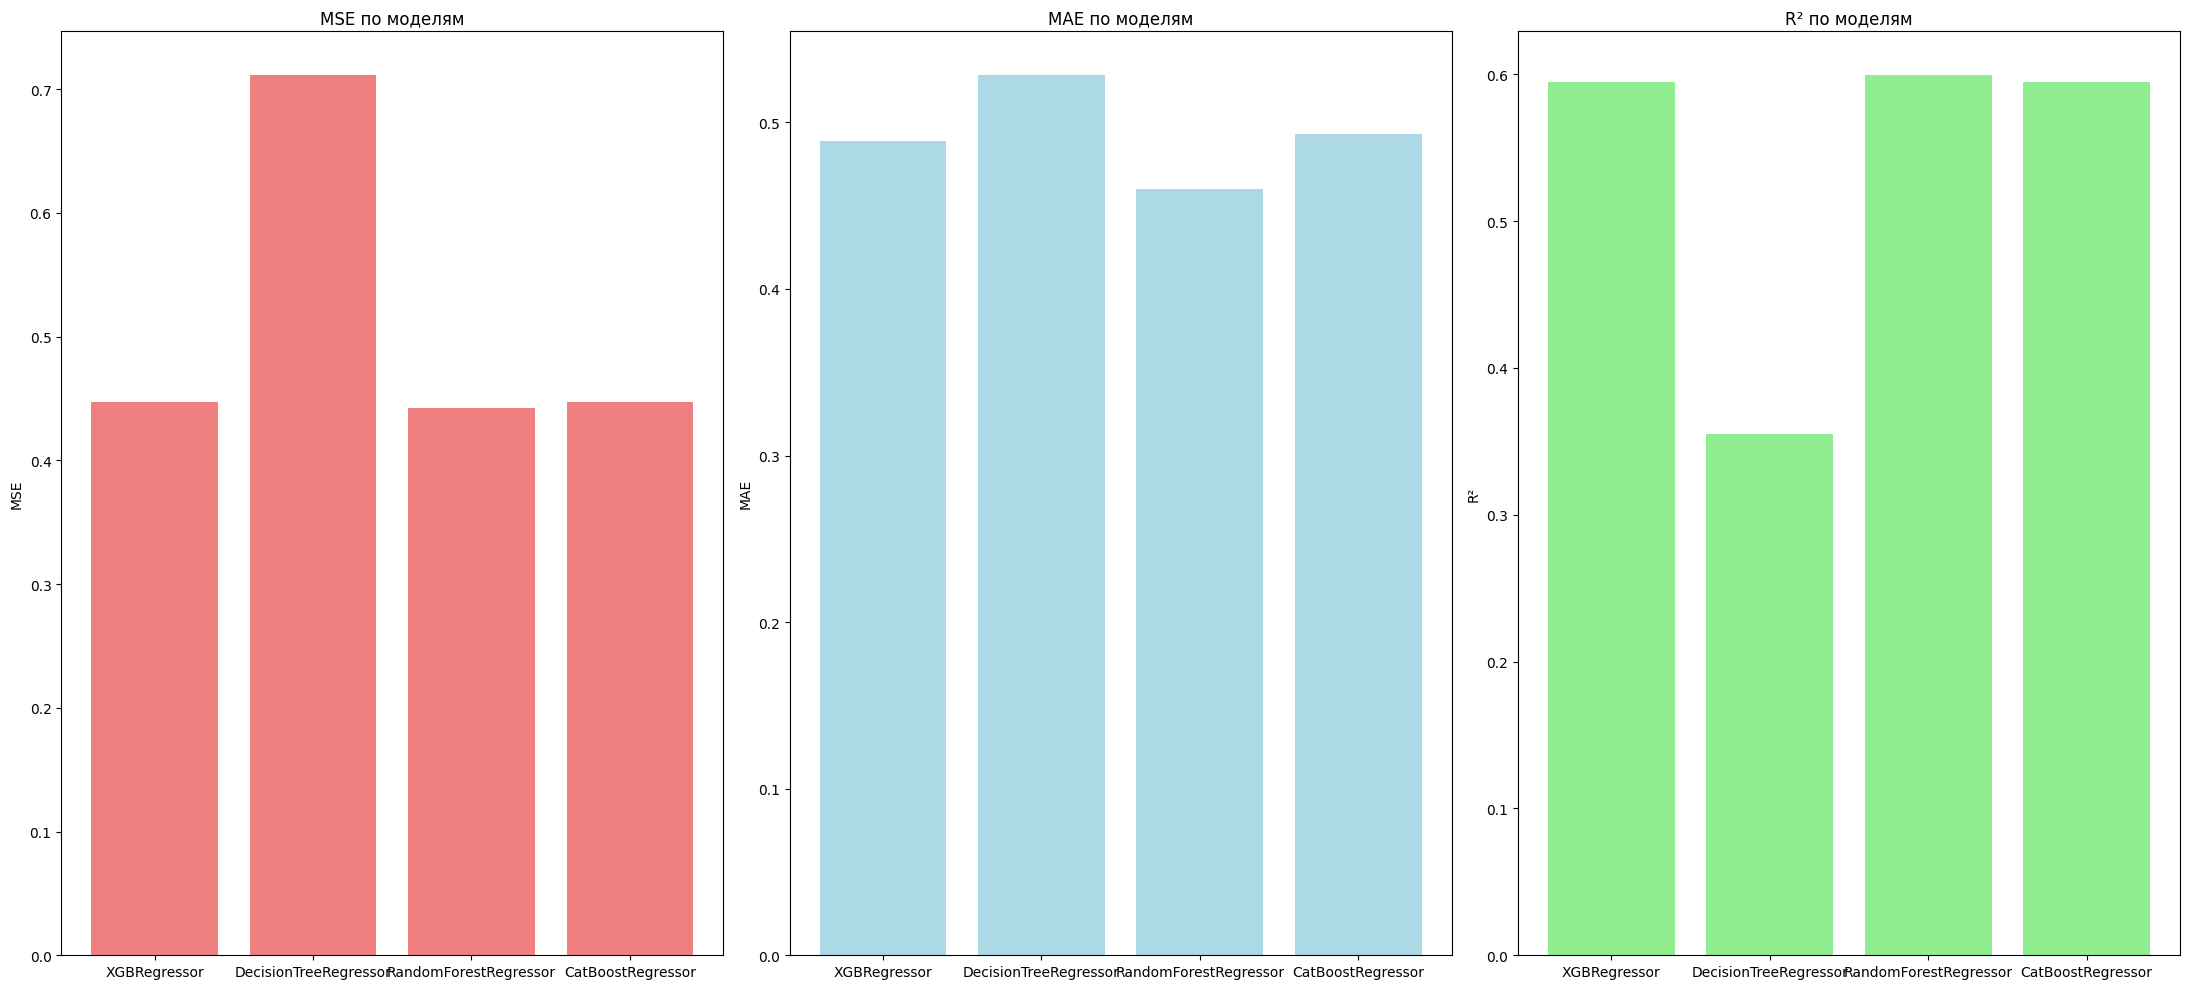

In [15]:
# Визуализация результатов
def plot_results(models_metrics):
    model_names = list(models_metrics.keys())
    mse_values = [metrics[0] for metrics in models_metrics.values()]
    mae_values = [metrics[1] for metrics in models_metrics.values()]
    r2_values = [metrics[2] for metrics in models_metrics.values()]

    plt.figure(figsize=(22, 10))

    plt.subplot(1, 3, 1)
    plt.bar(model_names, mse_values, color='lightcoral')
    plt.title('MSE по моделям')
    plt.ylabel('MSE')

    plt.subplot(1, 3, 2)
    plt.bar(model_names, mae_values, color='lightblue')
    plt.title('MAE по моделям')
    plt.ylabel('MAE')

    plt.subplot(1, 3, 3)
    plt.bar(model_names, r2_values, color='lightgreen')
    plt.title('R² по моделям')
    plt.ylabel('R²')

    plt.tight_layout()
    plt.show()

# Сохранение метрик для визуализации
metrics_dict = {name: (mse, mae, r2) for name, (mse, mae, r2) in zip(best_models.keys(), [(mean_squared_error(y_test, model_data['best_model'].predict(X_test)),
                       mean_absolute_error(y_test, model_data['best_model'].predict(X_test)),
                       r2_score(y_test, model_data['best_model'].predict(X_test)) ) for model_data in best_models.values()])}

plot_results(metrics_dict)

*На основании представленных данных с тестовыми показателями разных регрессоров, можно сделать следующие выводы:*

- Сравнение моделей
- *XGBRegressor*
- MSE: 0.4473
- MAE: 0.4886
- R²: 0.5944
- *DecisionTreeRegressor*
- MSE: 0.7112
- MAE: 0.5282
- R²: 0.3551
- *RandomForestRegressor*
- MSE: 0.4420
- MAE: 0.4601
- R²: 0.5993
- *CatBoostRegressor*
- MSE: 0.4470
- MAE: 0.4931
- R²: 0.5947
*Выводы*
- Лучшие показатели из всех моделей демонстрирует RandomForestRegressor, который имеет наименьший MSE (0.4420) и MAE (0.4601), а также самый высокий R² (0.5993), что указывает на хорошую предсказательную способность модели.
- XGBRegressor и CatBoostRegressor показывают схожие результаты, однако CatBoost имеет немного меньший MSE, но больший MAE по сравнению с XGBRegressor.
- DecisionTreeRegressor имеет наихудшие результаты среди рассмотренных моделей, с самым высоким MSE и MAE, а также самым низким R². Это говорит о том, что модель сильно переобучается и менее эффективна для данной задачи.
- *Рекомендации*
Для задач регрессии, судя по данной выборке, стоит отдавать предпочтение RandomForestRegressor из-за его лучших показателей.
В зависимости от конкретных требований и вычислительных ресурсов, могут также рассматриваться XGBRegressor и CatBoostRegressor.

*Данный код демонстрирует процесс сохранения и загрузки обученных моделей машинного обучения с использованием библиотеки `pickle` в Python.*

In [14]:
import pickle

# Сохранение обученных моделей в pickle файл
for regressor_name, model_data in best_models.items():
    # Сохраняем с добавлением _CC50
    filename = f"{regressor_name}_CC50.pkl"
    with open(filename, 'wb') as file:
        pickle.dump(model_data['best_model'], file)
        print(f"Модель '{filename}' сохранена.")

# Пример загрузки модели из pickle файла
def load_model(regressor_name):
    # Загрузка с одним добавлением _CC50
    filename = f"{regressor_name}_CC50.pkl"
    with open(filename, 'rb') as file:
        model = pickle.load(file)
    return model

# Загрузка моделей для использования
loaded_xgb = load_model('XGBRegressor')
loaded_dt = load_model('DecisionTreeRegressor')
loaded_rf = load_model('RandomForestRegressor')
loaded_catboost = load_model('CatBoostRegressor')

# # Проверка загруженной модели
# y_test_pred = loaded_catboost.predict(X_test)
# mse_loaded = mean_squared_error(y_test, y_test_pred)
# r2_loaded = r2_score(y_test, y_test_pred)


Модель 'XGBRegressor_CC50.pkl' сохранена.
Модель 'DecisionTreeRegressor_CC50.pkl' сохранена.
Модель 'RandomForestRegressor_CC50.pkl' сохранена.
Модель 'CatBoostRegressor_CC50.pkl' сохранена.
